In [3]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import pandas as pd

In [4]:
from spliceformats.readMATS import read_rmats
import logomaker as lm
import tqdm
#for g in tqdm.tqdm(np.unique(all_dfs.Gene)):

## **Read in relevant data and previous analyses**

In [5]:
#Annotations
#Get annotations
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            #pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    #pbar.update()
                    f.write(chunk)
        return fname


# #Uncomment to download again
# #Human ortholog annotations
# download_file('10.22002/D1.1819','.gz')

# #Panther annotations
# download_file('10.22002/D1.1820','.gz')

# #GO Terms
# download_file('10.22002/D1.1822','.gz')

#!gunzip *D1*.gz

In [6]:
#Read in annotation files
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True)
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True)
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [7]:
#Protein annotations (MSTRG --> XLOC mapping)
c_hem_nr_t2g = pd.read_csv('/home/tchari/clytia_alt_splice/reference/c_hem_nr_t2g.csv')
c_hem_nr_t2g.head()



,0,1,2,3,4,5,6,7,8,9
0,XLOC_019238,MSTRG.1,MSTRG.1.1.p1,MSTRG.1~~MSTRG.1.1.p1,NaN,ORF,type:complete,len:362,"(+),score=61.36",MSTRG.1.1:22-1107(+)
1,MASFYTPRKKTKMADNPGDIEITGYVNYVGPRKTSYFEVYLCDETK...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MSTRG.10,MSTRG.10.1.p1,MSTRG.10~~MSTRG.10.1.p1,NaN,ORF,type:complete,len:191,"(+),score=14.04",MSTRG.10.1:367-939(+),NaN
3,MIEDKITEEKSQKRLKLEKVTLTSNANQQQFDFNKQVIDIIEKSER...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,XLOC_004572,MSTRG.100,MSTRG.100.1.p1,MSTRG.100~~MSTRG.100.1.p1,NaN,ORF,type:complete,len:602,"(+),score=115.30,Y_phosphatase|PF00102.24|6.3e...",MSTRG.100.1:124-1929(+)


In [8]:
ins = pd.read_csv('~/clytia_alt_splice/reference/transdecoder_introns2.bed',header=None,sep='\t')
ins.head()

,0,1,2,3
0,SckGQDu_100;HRSCAF=164,28920,29747,MSTRG.1.1.p1|27692|29819
1,SckGQDu_102;HRSCAF=179,89407,138940,MSTRG.13.1.p1|89244|139738
2,SckGQDu_102;HRSCAF=179,89407,138940,MSTRG.13.1.p2|89244|139738
3,SckGQDu_110;HRSCAF=201,6919,15106,MSTRG.42.1.p1|6844|33003
4,SckGQDu_110;HRSCAF=201,16858,30796,MSTRG.42.1.p1|6844|33003


In [108]:
gff3 = pd.read_csv('/home/tchari/clytia_alt_splice/reference/transcripts.fa.transdecoder.genome.gff3',delimiter='\t', header=None)
gff3.head()


,0,1,2,3,4,5,6,7,8
0,SckGQDu_100;HRSCAF=164,transdecoder,gene,27692,29819,.,-,.,ID=MSTRG.1;Name=ORF%20type%3Acomplete%20len%3A...
1,SckGQDu_100;HRSCAF=164,transdecoder,mRNA,27692,29819,.,-,.,ID=MSTRG.1.1.p1;Parent=MSTRG.1;Name=ORF%20type...
2,SckGQDu_100;HRSCAF=164,transdecoder,five_prime_UTR,29799,29819,.,-,.,ID=MSTRG.1.1.p1.utr5p1;Parent=MSTRG.1.1.p1
3,SckGQDu_100;HRSCAF=164,transdecoder,exon,29747,29819,.,-,.,ID=MSTRG.1.1.p1.exon1;Parent=MSTRG.1.1.p1
4,SckGQDu_100;HRSCAF=164,transdecoder,CDS,29747,29798,.,-,0,ID=cds.MSTRG.1.1.p1;Parent=MSTRG.1.1.p1


In [110]:
gff3[['MSTRG.1.1.p1' in i for i in gff3[8]]] 

,0,1,2,3,4,5,6,7,8
1,SckGQDu_100;HRSCAF=164,transdecoder,mRNA,27692,29819,.,-,.,ID=MSTRG.1.1.p1;Parent=MSTRG.1;Name=ORF%20type...
2,SckGQDu_100;HRSCAF=164,transdecoder,five_prime_UTR,29799,29819,.,-,.,ID=MSTRG.1.1.p1.utr5p1;Parent=MSTRG.1.1.p1
3,SckGQDu_100;HRSCAF=164,transdecoder,exon,29747,29819,.,-,.,ID=MSTRG.1.1.p1.exon1;Parent=MSTRG.1.1.p1
4,SckGQDu_100;HRSCAF=164,transdecoder,CDS,29747,29798,.,-,0,ID=cds.MSTRG.1.1.p1;Parent=MSTRG.1.1.p1
5,SckGQDu_100;HRSCAF=164,transdecoder,exon,27692,28920,.,-,.,ID=MSTRG.1.1.p1.exon2;Parent=MSTRG.1.1.p1
6,SckGQDu_100;HRSCAF=164,transdecoder,CDS,27887,28920,.,-,2,ID=cds.MSTRG.1.1.p1;Parent=MSTRG.1.1.p1
7,SckGQDu_100;HRSCAF=164,transdecoder,three_prime_UTR,27692,27886,.,-,.,ID=MSTRG.1.1.p1.utr3p1;Parent=MSTRG.1.1.p1


In [9]:
sc_seq_df = pd.read_csv('sc_seq_withChrs_AGGT_ShortInt.csv',index_col=0)
sc_seq_df.head()

##sub[(sub[6]>10) & (sub[8]>20)]

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs
0,SckGQDu_9;HRSCAF=16,537154,537992,AAGGATGAATGGTTAGTATTCAAAACTCATT,TGACCAGTATTGCATTCTGACTTATTTTAGCGTTATGAATG,Ex_Int,GT/AG,False,NaN,False
1,SckGQDu_9;HRSCAF=16,658914,662439,AAGACACAATGGTATGTACCTGATTTAATAA,AAAAATAATCTGAAAATTGAAAAATCTGAGTTTAAACTGTA,Ex_Int,GT/AG,False,NaN,False
2,SckGQDu_9;HRSCAF=16,3022577,3030201,GCCCAATCAAGGTATGTTTTTTTTTGTTTGT,ACAGCTCATATCTTTGTTTTGATTTTGCAGATCGGGGTGAC,Ex_Int,GT/AG,False,NaN,False
3,SckGQDu_9;HRSCAF=16,7927344,8363934,TTGCAACGAAGGCTGTCTTACACACGATAAA,TTTATGATGTTACCAGTGGTTGCAACGAAGGCTGTCTTACA,Ex_Int,GC/AG,False,NaN,False
4,SckGQDu_9;HRSCAF=16,12341047,12345713,AATGCGGCAATGTCCATACTTTGAACCTGAA,CAGACTCTGGGCTTAAAGATAATAATAGAGGGGAAAAGACT,Ex_Int,GT/AG,False,NaN,False


In [10]:
pos_sjs = pd.read_csv('sc_pos_strand_sjs.csv',index_col=0)
pos_sjs.head()

#how many more of these, that map to introns + have U2/U12, versus the more filtered analysis?

,0,1,2,3,4,5,6,7,8,9,10,11
0,SckGQDu_1;HRSCAF=2,4212,4253,1,3,1,1,0,57,True,False,False
1,SckGQDu_1;HRSCAF=2,23431,24650,1,1,1,2,0,48,True,False,False
2,SckGQDu_1;HRSCAF=2,24699,25441,1,1,1,7,0,55,True,False,False
3,SckGQDu_1;HRSCAF=2,69392,69578,1,1,1,1,0,49,True,False,False
7,SckGQDu_1;HRSCAF=2,118646,118771,1,1,1,3,0,43,True,False,False


In [150]:
real_introns_bulk_df = pd.read_csv('real_introns_bulk_seq.csv')
real_introns_bulk_df.head()

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,St_End_Recurs,Short_Intron,AGGT_Dists,length
0,SckGQDu_9;HRSCAF=16,426716,427189,CCGATGTAAAGGTATAATCAATTGATATTTT,AATTTAATCAAGACTATCTTTCTCTTTCAGGCCTATATGGA,Ex_Ex,GT/AG,False,False,NaN,473
1,SckGQDu_9;HRSCAF=16,427296,428266,CGCAATCACAGGTAATAATTTGCACCAGGAA,TCTTTCAGCTATCTTGCTATCGTTTTTCAGGTCAGCTTGAC,Ex_Ex,GT/AG,False,False,NaN,970
2,SckGQDu_9;HRSCAF=16,428410,428625,AGAAGGGCGAGGTACATTCCTTTTTTTAAGC,ATTTTATCTTCTTTTTTTTAATTCTTCTAGATGACGCTTCG,Ex_Ex,GT/AG,False,False,NaN,215
3,SckGQDu_9;HRSCAF=16,428903,429146,GTCTAACAAAGGTAAGGTGTTAGTGGCATTA,AAATCTGACGTCCTGGTTTCCATATTGCAGGTCTTTCTGGT,Ex_Ex,GT/AG,False,False,NaN,243
4,SckGQDu_9;HRSCAF=16,429255,429686,ACACTCTTTAGGTAAGCCTATTTCTTGTGTA,TCATTACACAAACTACTCTTTTCTTTGCAGGATTGGCTCAC,Ex_Ex,GT/AG,False,False,NaN,431


In [11]:
def get_sj_seqs(sj_df,st_minus=10,end_plus=30,upper=True):
    my_list = []
    for i in range(len(sj_df)):
        chrom = sj_df.iloc[i][0]
        start = sj_df.iloc[i][1]
        end = sj_df.iloc[i][2]
    
        my_list += [[chrom,start-st_minus,end+end_plus]] #-10,30

    #Get sequence -10 and +30 around the splice junction ends
    with open("bounds.tsv", "w") as f:
        for row in my_list:
            f.write("\t".join(map(str, row)) + "\n")

    !bedtools getfasta -fi /home/tchari/clytia_alt_splice/reference/clytia_hic_output.fasta -bed bounds.tsv -fo sj_seq.fa.out

    with open('sj_seq.fa.out',) as f:
        raw_seqs = f.readlines()

    !rm bounds.tsv
    !rm sj_seq.fa.out

    seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]
    if upper:
        seqs = [i.upper() for i in seqs]
        
    return seqs

# Col 3: 5_SS  : sequence from -10…+20, where +1,+2 is the /GT (or /AT)
# Col 4: 3_SS : sequence from -30…+10, where –2,–1 is the AG/ (or AC/)


# seqs = get_sj_seqs(sub,st_minus=12,end_plus=30)

# counts_mat = lm.alignment_to_matrix([i[0:30]for i in seqs],to_type='information') #or [-60:-19]
# lm.Logo(counts_mat,color_scheme='classic')

In [12]:
def hamming_dist(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strand lengths are not equal!")
    else:
        return sum(1 for (a, b) in zip(str1, str2) if a != b)

## **Analysis of U2/U12-containing introns**

1. Stricter definition of U2 and U12-containing introns (overlap with introns bed?)
2. Manually look for different categories of U2 and U12-containing introns
3. Are surrounding exons alternative? The transcripts in general?

In [ ]:
#what are the different categories of U2 and U12-containing introns

#look for 5' AGGT or GTAAG (L or R-handed) + U12 bp or 5'SS


/tmp/ipykernel_2965681/1053824825.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = sj_df.iloc[i][0]
/tmp/ipykernel_2965681/1053824825.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = sj_df.iloc[i][1]
/tmp/ipykernel_2965681/1053824825.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = sj_df.iloc[i][2]
/home/tchari/rmats_conda_env/lib/python3.10/site-packages/logomaker/src/matrix.py:270: FutureWarning: Set

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,Transcript,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count
0,SckGQDu_3;HRSCAF=8,223987,224191,TGCTGAAACTGGTTGGTATATTTTGTTTGTG,ATTCTTTCTCCTTTTTTTTGGATAATCTAGGTCAAAGGATC,Ex_Ex,GT/AG,False,NaN,False,205,MSTRG.21059.2.p1,False,False,False,False,NaN,NaN,NaN
1,SckGQDu_3;HRSCAF=8,224261,224377,ATCAAATACTGGTAAATGTGCAGCTACATTA,ATTTCCACTCTTTCTTGTTATTTTCATCAGTAATCACTGCA,Ex_Ex,GT/AG,False,NaN,False,117,MSTRG.21059.1.p1,False,False,False,False,NaN,NaN,NaN
2,SckGQDu_8;HRSCAF=15,355731,356010,ATTTTTCAGTGGTAAGTCATTTTTGAACTTT,TATTCAATTTTCATCGAATTCCTTTTGTAGATGATGTCAAG,Ex_Ex,GT/AG,False,NaN,False,280,MSTRG.23218.1.p1,True,False,False,True,NaN,142.0,1.0
3,SckGQDu_9;HRSCAF=16,426716,427189,CCGATGTAAAGGTATAATCAATTGATATTTT,AATTTAATCAAGACTATCTTTCTCTTTCAGGCCTATATGGA,Ex_Ex,GT/AG,False,NaN,False,474,MSTRG.24540.1.p1,False,True,False,False,NaN,NaN,NaN
4,SckGQDu_9;HRSCAF=16,427296,428266,CGCAATCACAGGTAATAATTTGCACCAGGAA,TCTTTCAGCTATCTTGCTATCGTTTTTCAGGTCAGCTTGAC,Ex_Ex,GT/AG,False,NaN,False,971,MSTRG.24540.1.p1,False,True,False,False,NaN,NaN,NaN


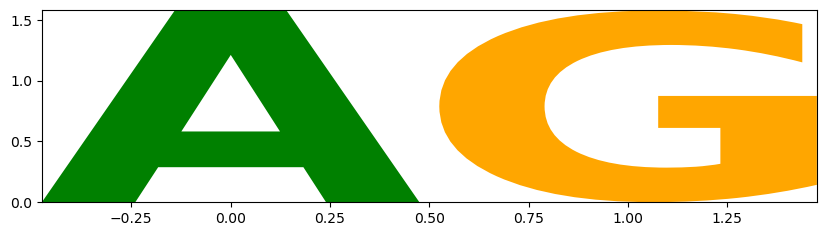

In [111]:
#sub = sc_seq_df[sc_seq_df.SJ_Type=='Ex_Ex'] #Can add additional introns_df filter~!!!!!
sub = pd.read_csv('real_introns_sc_seq.csv')

seqs = get_sj_seqs(sub,st_minus=12,end_plus=30)

counts_mat = lm.alignment_to_matrix([i[-32:-30]for i in seqs],to_type='information') #or [-60:-19]
lm.Logo(counts_mat,color_scheme='classic')

u12_bp = [False]*len(seqs)
bp_ind = [np.nan]*len(seqs)

u12_5ss = [False]*len(seqs)
ss5_ind = [np.nan]*len(seqs)
ss5_count = [np.nan]*len(seqs)

u2_L = [False]*len(seqs)
u2_R = [False]*len(seqs)
for s in range(len(seqs)):
    u2_R[s] = ((seqs[s][11:16] == 'GTAAG') & (seqs[s][-32:-30] == 'AG'))
    u2_L[s] = ((seqs[s][9:13] == 'AGGT') & (seqs[s][-32:-30] == 'AG'))

    bp_true = ('TCCTTAAC' in seqs[s])
    u12_bp[s] = bp_true
    if bp_true:
        bp_ind[s] = seqs[s].index('TCCTTAAC')
        
    ss5_true = (('GTATCCTT' in seqs[s]) or ('ATATCCTT' in seqs[s]))  # *************** SAVE INDICES TOO
    u12_5ss[s] = ss5_true 
    if ss5_true:
        if ('GTATCCTT' in seqs[s]):
            ss5_ind[s] = seqs[s].index('GTATCCTT')
            ss5_count[s] = seqs[s].count('GTATCCTT')
        else:
            ss5_ind[s] = seqs[s].index('ATATCCTT')
            ss5_count[s] = seqs[s].count('ATATCCTT')


u2_u12_df = sub.copy()
u2_u12_df['U2_R'] = u2_R
u2_u12_df['U2_L'] = u2_L
u2_u12_df['U12_BP'] = u12_bp
u2_u12_df['U12_5SS'] = u12_5ss

u2_u12_df['U12_BP_Ind'] = bp_ind
u2_u12_df['U12_5SS_Ind'] = ss5_ind
u2_u12_df['U12_5SS_Count'] = ss5_count
u2_u12_df.head()


In [116]:
pd.Categorical(u2_u12_df.U12_5SS_Count).value_counts()

1.0     879
2.0      56
3.0      11
4.0       8
5.0       2
7.0       2
22.0      1
Name: count, dtype: int64

In [122]:
#Look for 'tandem' ones

**Are any U12 seqs used**

In [143]:
u12_pos_df = u2_u12_df[(u2_u12_df.U12_5SS_Ind==u2_u12_df.U12_5SS_Ind)] #| (u2_u12_df.U12_BP_Ind==u2_u12_df.U12_BP_Ind)
u12_pos_df['True_Start'] = ((u12_pos_df.U12_5SS_Ind-11)+u12_pos_df.Start).astype(int)
u12_pos_df

/tmp/ipykernel_2965681/3446165544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u12_pos_df['True_Start'] = ((u12_pos_df.U12_5SS_Ind-11)+u12_pos_df.Start).astype(int)


,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,Transcript,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start
2,SckGQDu_8;HRSCAF=15,355731,356010,ATTTTTCAGTGGTAAGTCATTTTTGAACTTT,TATTCAATTTTCATCGAATTCCTTTTGTAGATGATGTCAAG,Ex_Ex,GT/AG,False,NaN,False,280,MSTRG.23218.1.p1,True,False,False,True,NaN,142.0,1.0,355862
99,SckGQDu_9;HRSCAF=16,1663388,1663979,CTGAGAAAGTGGTAAGTATATAAATGATTTT,AAAAAATCCTATTGTTTTATAAAATGTCAGGTTGAAATTTC,Ex_Ex,GT/AG,False,NaN,False,592,MSTRG.24633.1.p1,True,False,False,True,NaN,565.0,1.0,1663942
113,SckGQDu_9;HRSCAF=16,1796457,1817332,GGTACTCCCAGGTACGGACTTTATCGTTCAA,ACTATAATATCGACTCGATTCTTTCATCAGGAAAAGACGAA,Ex_Ex,GT/AG,False,NaN,False,20876,MSTRG.24640.1.p1,False,True,False,True,NaN,4309.0,1.0,1800755
155,SckGQDu_9;HRSCAF=16,2056035,2056420,GTACAAGTTCAGTAAGTTTTGTTATTAGTTG,TTTTTAATGGTAAGATAAATTCTCTATTAGAGTGGAAAATC,Ex_Ex,GT/AG,False,NaN,False,386,MSTRG.24658.1.p1,True,False,False,True,NaN,326.0,1.0,2056350
158,SckGQDu_9;HRSCAF=16,2057216,2057564,ACCTTCTGCAGGTAAGAAATATCTAGAAAGA,ACTAGAACAATATTTAATTTCTGACCTTAGATTCAAGTAAG,Ex_Ex,GT/AG,False,NaN,False,349,MSTRG.24658.1.p1,True,True,False,True,NaN,217.0,2.0,2057422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,SckGQDu_198;HRSCAF=491,20413125,20416428,CGATTACAAAGGTGAGGGAAATTTGTCTAGG,TCAACTGTATTTTGACTTCTTTTGTTTTAGCCGATTGGTTA,Ex_Ex,GT/AG,False,NaN,False,3304,MSTRG.19523.1.p1,False,True,False,True,NaN,2823.0,1.0,20415937
23224,SckGQDu_198;HRSCAF=491,21829315,21830178,GAAGACCGCTGGTAAACAAAGCCATTGAAAT,ATGATGACATTTCTTTTGGTTCTTTTTTAGGATATCCTTCA,Ex_Ex,GT/AG,False,NaN,False,864,MSTRG.19593.3.p1,False,False,False,True,NaN,876.0,1.0,21830180
23326,SckGQDu_110;HRSCAF=201,25648020,25648562,TATGTGGAGTGGTATCCTTTTCAATCGAATT,TTCCTTAACTCTGAGCCATCCGTAATACAGCTTCTTGGTTT,Ex_Ex,GT/AG,False,NaN,False,543,MSTRG.1843.1.p1,False,False,True,True,525.0,11.0,1.0,25648020
23341,SckGQDu_148;HRSCAF=334,7877118,7878556,ATACTTTAAAGGTAAATTTTGGTTCTTTTGT,TATAATGTATTATCCTTCTTTCATGTATAGGCTGGCGTCAC,Ex_Ex,GT/AG,False,NaN,False,1439,MSTRG.6399.1.p1,False,True,False,True,NaN,789.0,1.0,7877896


In [169]:
# plt.hist(u12_pos_df.U12_5SS_Ind-11)
# plt.hist(u12_pos_df.U12_BP_Ind-11,alpha=0.7)
# #_=plt.xscale('log')

In [179]:
#How far apart are tandem ones

seqs = get_sj_seqs(u12_pos_df[u12_pos_df.U12_5SS_Count>1],st_minus=12,end_plus=30)

import re
import itertools
all_dists = []
which_ind = []
for i in range(len(seqs)):
    s = seqs[i]
    pos = [m.start() for m in re.finditer('GTATCCTT', s)]+[m.start() for m in re.finditer('ATATCCTT', s)] #(('GTATCCTT' in seqs[s]) or ('ATATCCTT' in seqs[s]))
    all_dists += [abs(x - y) for x, y in itertools.combinations(pos, 2)]
    which_ind += [i]*len([abs(x - y) for x, y in itertools.combinations(pos, 2)])

/tmp/ipykernel_2965681/1053824825.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = sj_df.iloc[i][0]
/tmp/ipykernel_2965681/1053824825.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = sj_df.iloc[i][1]
/tmp/ipykernel_2965681/1053824825.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = sj_df.iloc[i][2]


In [183]:
np.array(which_ind)[np.array(all_dists)<30]

array([ 7, 29, 29, 29, 29, 35, 39, 51])

In [185]:
t = u12_pos_df[u12_pos_df.U12_5SS_Count>1]
t.iloc[np.array(which_ind)[np.array(all_dists)<30]] #2418 ,10470*	(~200bp away there are reads)

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,...,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start,Uniq_Reads,Junc_Uniq_Reads
2418,SckGQDu_13;HRSCAF=20,22188131,22188843,AGTTGTAGCAAGTAAGTTACCAAACTGCAAC,CACAAATTAGAGAATTTTTTCAACTTTCAGTTCGCCATCTT,Ex_Ex,GT/AG,False,NaN,False,...,True,False,False,True,NaN,416.0,2.0,22188536,0,0
10470,SckGQDu_110;HRSCAF=201,12936216,12940196,TCCCCAAGATTGTAAGTATTTTTTTTTTATT,AATGATTAATTCGCATTATTCCGTTCCCAGGACAACACCGA,Ex_Ex,GT/AG,False,NaN,False,...,True,False,True,True,2141.0,2393.0,4.0,12938598,0,0
10470,SckGQDu_110;HRSCAF=201,12936216,12940196,TCCCCAAGATTGTAAGTATTTTTTTTTTATT,AATGATTAATTCGCATTATTCCGTTCCCAGGACAACACCGA,Ex_Ex,GT/AG,False,NaN,False,...,True,False,True,True,2141.0,2393.0,4.0,12938598,0,0
10470,SckGQDu_110;HRSCAF=201,12936216,12940196,TCCCCAAGATTGTAAGTATTTTTTTTTTATT,AATGATTAATTCGCATTATTCCGTTCCCAGGACAACACCGA,Ex_Ex,GT/AG,False,NaN,False,...,True,False,True,True,2141.0,2393.0,4.0,12938598,0,0
10470,SckGQDu_110;HRSCAF=201,12936216,12940196,TCCCCAAGATTGTAAGTATTTTTTTTTTATT,AATGATTAATTCGCATTATTCCGTTCCCAGGACAACACCGA,Ex_Ex,GT/AG,False,NaN,False,...,True,False,True,True,2141.0,2393.0,4.0,12938598,0,0
11517,SckGQDu_110;HRSCAF=201,29205985,29212045,CACCTCGGAAGGTATTTTCATATTTACTTTT,TTATAATTTATAATTATAATTTTATTACAGAAATGTTTTTC,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,2354.0,22.0,29208328,0,0
13577,SckGQDu_148;HRSCAF=334,1472411,1472781,TATACTCTGAGGTAAGTGACCTTTCAGTATT,TGTAACCATTACATCATTTCTGGCCAATAGGAAGAAGAGGA,Ex_Ex,GT/AG,False,NaN,False,...,True,True,False,True,NaN,205.0,2.0,1472605,0,0
17972,SckGQDu_151;HRSCAF=341,1695019,1705372,GCCAAAGCTAAGTATGTTTTTTTCATTATCA,TAACACGAAAATTCTTTTTCCACATTTTAGAGAAAACAAGC,Ex_Ex,GT/AG,False,NaN,False,...,False,False,False,True,NaN,5243.0,3.0,1700251,0,0


(array([ 2.,  6.,  1.,  5.,  1.,  4.,  2.,  8.,  0.,  7.,  6.,  8., 53.,
         7., 10.,  8., 35., 13., 20., 16., 20., 18., 17., 25., 34., 27.,
        31.,  8.,  6.,  9., 14., 10.,  8.,  7., 11.,  8., 11.,  2., 12.,
        14., 18., 12., 15., 10., 10.,  7.,  7.,  6.,  6.,  4.]),
 array([1.30103   , 1.37748362, 1.45393724, 1.53039087, 1.60684449,
        1.68329812, 1.75975174, 1.83620537, 1.91265899, 1.98911261,
        2.06556624, 2.14201986, 2.21847349, 2.29492711, 2.37138073,
        2.44783436, 2.52428798, 2.60074161, 2.67719523, 2.75364886,
        2.83010248, 2.9065561 , 2.98300973, 3.05946335, 3.13591698,
        3.2123706 , 3.28882423, 3.36527785, 3.44173147, 3.5181851 ,
        3.59463872, 3.67109235, 3.74754597, 3.8239996 , 3.90045322,
        3.97690684, 4.05336047, 4.12981409, 4.20626772, 4.28272134,
        4.35917496, 4.43562859, 4.51208221, 4.58853584, 4.66498946,
        4.74144309, 4.81789671, 4.89435033, 4.97080396, 5.04725758,
        5.12371121]),
 <BarContainer

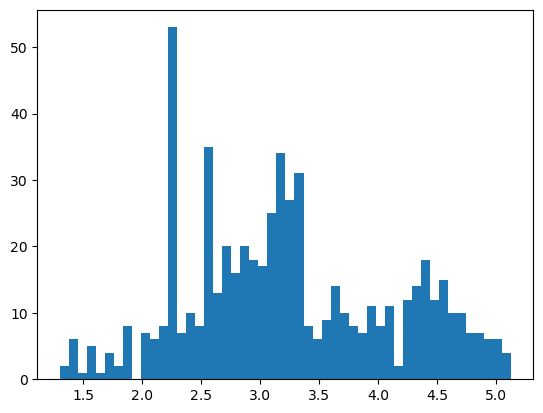

In [180]:
plt.hist(np.log10(all_dists),bins=50)


In [151]:
# *** GET uniq reads for juncs that start at U12 ****
uniq_reads_u12_5ss = np.array([0]*len(u12_pos_df))
for i in range(len(u12_pos_df)):
    s = u12_pos_df.iloc[i]
    chrs = s.Chr
    st = s.Start
    new_st = s.True_Start
    filt = ((pos_sjs['1']==new_st) & (pos_sjs['0']==chrs))
    if np.sum(filt) > 0:
        uniq_reads_u12_5ss[i] = np.sum(pos_sjs['6'][filt])


In [154]:
u12_pos_df['Junc_Uniq_Reads'] = uniq_reads_u12_5ss
u12_pos_df[u12_pos_df.Junc_Uniq_Reads > 0]

/tmp/ipykernel_2965681/2530306635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u12_pos_df['Junc_Uniq_Reads'] = uniq_reads_u12_5ss


,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,...,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start,Uniq_Reads,Junc_Uniq_Reads
1311,SckGQDu_13;HRSCAF=20,2176334,2381243,CTGAGTATAAGGTATGTATCAGGCTTATGCT,TCGTTTCATTCTGTTTTTTTATCGTTATAGCAGCTAGAATA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,18374.0,135648.0,2.0,2311971,276,2
2262,SckGQDu_13;HRSCAF=20,18242600,18243591,ATACTTCCTGCGTATCCTTTTCATGAACAAA,CCTTGACAATTTCTTACAATATTTTCACAGTATTATAATAT,Ex_Ex,GT/AG,False,NaN,False,...,False,False,False,True,NaN,11.0,1.0,18242600,0,165
2475,SckGQDu_13;HRSCAF=20,23075866,23076597,TTCTCATGACTGTATCCTTTTCTCTTGAAAT,CTTTAACTTTTATACCACATTGTACACCAGATAATAGCGTT,Ex_Ex,GT/AG,False,NaN,False,...,False,False,False,True,NaN,11.0,1.0,23075866,0,13
2596,SckGQDu_17;HRSCAF=24,477013,477611,CAAACTGTGTGATATCCTTTTCTGAAATTTA,AGAAGACTTTTTCCTTAACAATGGGTGTACATTTGGTTTGG,Ex_Ex,AT/AC,False,NaN,False,...,False,False,True,True,591.0,11.0,1.0,477013,0,256
2930,SckGQDu_17;HRSCAF=24,3204614,3204734,TCAATTTACAGGTATCCTTAAATTATGGATT,TTTTATAAAACTTTTTTTCTTAAAATTTAGATTCAGATGGA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,11.0,1.0,3204614,0,11
3141,SckGQDu_17;HRSCAF=24,5667324,5668830,GACTTGAAAAGGTATCCTTTTGTTTTTTGTT,AAACTCTTTCCACTCCGTTTATATTATCAGATTATCATTTT,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,11.0,1.0,5667324,0,21
3658,SckGQDu_17;HRSCAF=24,13674998,13675322,CTTTCTTTTGTGTATCCTTTTCCACTCACTT,TTTGTCCTTAACTTTACTTACATAATATAGATGCATGCGTC,Ex_Ex,GT/AG,False,NaN,False,...,False,False,True,True,310.0,11.0,1.0,13674998,0,2306
4136,SckGQDu_17;HRSCAF=24,19707617,19707910,ACACAGTAGTTGTATCCTTTCATCATTCCAC,TTCCTTAACTTTCGTTCATTAAAACTGAAGGCCATAATGGC,Ex_Ex,GT/AG,False,NaN,False,...,False,False,True,True,276.0,11.0,1.0,19707617,0,12788
4240,SckGQDu_17;HRSCAF=24,20696295,20696440,TCCCTGGATTTGTATCCTTTTCAAAGAATTT,CCTTAACATTTTTATCAATAATAATAATAGATGTGCCAGGG,Ex_Ex,GT/AG,False,NaN,False,...,False,False,True,True,126.0,11.0,1.0,20696295,0,444
4950,SckGQDu_17;HRSCAF=24,30393763,30394194,CTTCTTCAAAAATATCCTTTTCATTATGTTT,CTTAACGAAGAATTGCTCTCATTCGAATACGCATGTGCATG,Ex_Ex,AT/AC,False,NaN,False,...,False,False,True,True,411.0,11.0,1.0,30393763,0,1278


In [155]:
# *** GET uniq reads for juncs that start at U12 ****
uniq_reads_u12_5ss = np.array([0]*len(u12_pos_df))
for i in range(len(u12_pos_df)):
    s = u12_pos_df.iloc[i]
    chrs = s.Chr
    st = s.Start
    new_st = s.True_Start
    filt = ((pos_sjs['1']>st) & (pos_sjs['1']<new_st) & (pos_sjs['0']==chrs))
    if np.sum(filt) > 0:
        uniq_reads_u12_5ss[i] = np.sum(pos_sjs['6'][filt])


In [156]:
u12_pos_df['Uniq_Reads'] = uniq_reads_u12_5ss
u12_pos_df[u12_pos_df.Uniq_Reads > 0]

/tmp/ipykernel_2965681/4233174473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u12_pos_df['Uniq_Reads'] = uniq_reads_u12_5ss


,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,...,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start,Uniq_Reads,Junc_Uniq_Reads
668,SckGQDu_9;HRSCAF=16,10849050,10875009,TGGCTGAAGAGGTAAGTTGAGAATAATTTAT,CCTTAGAATTCATGATTATCTATTTTTCAGTTACGTAACGA,Ex_Ex,GT/AG,False,NaN,False,...,True,True,False,True,NaN,24074.0,1.0,10873113,729,0
854,SckGQDu_9;HRSCAF=16,14807186,14814403,ATTTTTTTAAGGTAATTTTAGCTTTTTTGTC,ATAACTTTTCGTATTATTTTTTGCATTCAGAAACGTGATTC,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,3913.0,1.0,14811088,1,0
1158,SckGQDu_13;HRSCAF=20,736974,749555,AGTGTTTATAAGTATGTTTTAATCATTTTAA,TTCGTCAACATTTTTCTTCATTCTCTCAAGTACACGGATCC,Ex_Ex,GT/AG,False,NaN,False,...,False,False,False,True,NaN,6752.0,1.0,743715,21,0
1165,SckGQDu_13;HRSCAF=20,753944,778371,GTATTAACTTTGTAAGTTTATTGATTTATTC,TTTCAAAATCTTCTTCTTCTTTTTTTACAGAACATCAACGC,Ex_Ex,GT/AG,False,NaN,False,...,True,False,False,True,NaN,3442.0,2.0,757375,4,0
1311,SckGQDu_13;HRSCAF=20,2176334,2381243,CTGAGTATAAGGTATGTATCAGGCTTATGCT,TCGTTTCATTCTGTTTTTTTATCGTTATAGCAGCTAGAATA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,18374.0,135648.0,2.0,2311971,276,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21999,SckGQDu_197;HRSCAF=482,24464604,24479211,AGAAGAGCAAGGTAAATTTCCAATTTCCAGT,TAATTTAACAATTTCTTTTACACTTTACAGAAAATTGGAAA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,11998.0,1.0,24476591,1,0
22127,SckGQDu_197;HRSCAF=482,26341347,26344638,ATAACATCAAGGTAATTCCATTGATCCAAAC,TTCATCTTGTGTTTCTCTTCTCTTGTTCAGGGTTCGTATCC,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,3308.0,1.0,26344644,4,0
22135,SckGQDu_197;HRSCAF=482,26537119,26540157,ATTTCATAAAGGTACGGGTGTCAACCATGGA,TACCATTTCCACATTTTTCTCTTCTTGTAGGGGGCCAAGGT,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,2230.0,1875.0,1.0,26538983,1,0
22650,SckGQDu_198;HRSCAF=491,8117854,8133355,ATTACTGACGGGTAATATAACGCTTTTGTAG,CTCAATATTTGCCTATAATTTGAATTTCAGATGTCCCAATA,Ex_Ex,GT/AG,False,NaN,False,...,False,False,False,True,NaN,3221.0,2.0,8121064,8028,0


In [157]:
u12_pos_df[(u12_pos_df.Uniq_Reads > 0) & (u12_pos_df.U12_5SS_Count > 1)]

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,...,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start,Uniq_Reads,Junc_Uniq_Reads
1165,SckGQDu_13;HRSCAF=20,753944,778371,GTATTAACTTTGTAAGTTTATTGATTTATTC,TTTCAAAATCTTCTTCTTCTTTTTTTACAGAACATCAACGC,Ex_Ex,GT/AG,False,NaN,False,...,True,False,False,True,NaN,3442.0,2.0,757375,4,0
1311,SckGQDu_13;HRSCAF=20,2176334,2381243,CTGAGTATAAGGTATGTATCAGGCTTATGCT,TCGTTTCATTCTGTTTTTTTATCGTTATAGCAGCTAGAATA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,18374.0,135648.0,2.0,2311971,276,2
1996,SckGQDu_13;HRSCAF=20,13817279,13924407,CCGTGATCGAGGTGGCAGAGGCGGTGGTGGA,GGCGTGGTGGAAGAGGTGGCCGTGATCGAGGTGATCGAGGT,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,6502.0,7554.0,7.0,13824822,2705,0
3418,SckGQDu_17;HRSCAF=24,9752019,9772748,ACTATCGTCAGGTAATCTTCCGTTTATTTCC,TTGACGCTAATGAAATGATTTTATTTGTAGGGAATTCTTAA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,4948.0,2.0,9756956,1,0
4550,SckGQDu_17;HRSCAF=24,25317528,25332813,AGATGGGGCAGGTAGGAAGCGATTACATTGA,CTATAAAATCACTTTTTGTTATGTGTGTAGGATGAGTTACA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,10584.0,2.0,25328101,28,0
6837,SckGQDu_83;HRSCAF=119,9290462,9350361,GCTTGATTAAGGTATGATTTTTTTCTATGTT,GACTCCTTATTCAATCTTTCAAATGAATAGGATTGCAAGTT,Ex_Ex,GT/AG,False,NaN,False,...,False,True,True,True,46506.0,7490.0,3.0,9297941,735,0
6840,SckGQDu_83;HRSCAF=119,9346812,9367264,GCTTGCTTAAGGTATGGCTTTTTTCAATGTT,GACTTCTTATTCAATCTTTCAAATGAACAGGATTGCAAGTT,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,17025.0,5.0,9363826,3,0
8336,SckGQDu_90;HRSCAF=138,3421272,3435622,AGAAGAAGATGGTAAGCTGACTTAAGCATGT,TGAACAACATTTTTCATCTCTTTCCAATAGAAGAAACGGAC,Ex_Ex,GT/AG,False,NaN,False,...,True,False,True,True,9089.0,2740.0,4.0,3424001,1,0
10232,SckGQDu_110;HRSCAF=201,10160849,10187248,TTAATACTACTGTAAGCAAATAGGCCCTTTA,GCTCCAGTACAAATGTAAACCCACCCTAAGCAAATAGGCAA,Ex_Ex,GT/AG,False,NaN,False,...,True,False,False,True,NaN,7583.0,2.0,10168421,1,0
10645,SckGQDu_110;HRSCAF=201,16378740,16390885,TTATCACTGAGGTACACGTTTTATCTTTTAT,AAAAATGTTTTTTTTTCCTTATTTCACCAGCTTTGGAAGAA,Ex_Ex,GT/AG,False,NaN,False,...,False,True,False,True,NaN,4460.0,2.0,16383189,4,0


In [ ]:
#SckGQDu_198;HRSCAF=491	8118457	8134004	

In [ ]:
#Distance between sites where U12_5SS_Count




In [138]:
u12_pos_df = u2_u12_df[(u2_u12_df.U12_BP_Ind==u2_u12_df.U12_BP_Ind)] #| (u2_u12_df.U12_BP_Ind==u2_u12_df.U12_BP_Ind)
u12_pos_df['True_Start'] = ((u12_pos_df.U12_BP_Ind-11)+u12_pos_df.Start).astype(int)
u12_pos_df

/tmp/ipykernel_2965681/1152034076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u12_pos_df['True_Start'] = ((u12_pos_df.U12_BP_Ind-11)+u12_pos_df.Start).astype(int)


,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,Transcript,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start
128,SckGQDu_9;HRSCAF=16,1827053,1827738,TTCGATGAAAAGTAAGCTCATTTTAGCCGTT,TGTGAGCAATAACTTTGGTGTCCATTTCAGCTACGAAGTCA,Ex_Ex,GT/AG,False,NaN,False,686,MSTRG.24640.1.p1,True,False,True,False,108.0,NaN,NaN,1827150
135,SckGQDu_9;HRSCAF=16,1861767,1862633,AAGTTTACCTAGTAAGTAAACTTTCAGTTGT,CTGACTATTATATTTTCTCAAAATTTTTAGGGCTTAGCGGA,Ex_Ex,GT/AG,False,NaN,False,867,MSTRG.24647.1.p1,True,False,True,False,607.0,NaN,NaN,1862363
170,SckGQDu_9;HRSCAF=16,2099046,2099617,CAAAATTTATGGTAATTTATATCGATTTCTG,CACTGTAGAAGTTGTGATACTTTTATTCAGGGAGTTTGTAA,Ex_Ex,GT/AG,False,NaN,False,572,MSTRG.24661.1.p1,False,False,True,False,207.0,NaN,NaN,2099242
257,SckGQDu_9;HRSCAF=16,2758511,2760389,ACGTTGTGATGGTATTATTATAAACTAATTC,ATACTTTATTTTGGTTTTATATTTCCTTAGTGCGAAACCAT,Ex_Ex,GT/AG,False,NaN,False,1879,MSTRG.24708.1.p1,False,False,True,False,903.0,NaN,NaN,2759403
275,SckGQDu_9;HRSCAF=16,2927316,2928527,TTTTCTTACAGGTAAGTTACTAGTCTAGAAT,AACCCAAACTCTCATTCTCTTTTCTTTCAGTATCAATATTT,Ex_Ex,GT/AG,False,NaN,False,1212,MSTRG.24715.1.p1,True,True,True,True,444.0,985.0,1.0,2927749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23073,SckGQDu_198;HRSCAF=491,17872132,17875669,AATCAAAGATGGTAAGAACTATATGCTTTTT,GTGATTGTAAATTATTTTCTTTTCCCAAAGCATTCAAACCA,Ex_Ex,GT/AG,False,NaN,False,3538,MSTRG.19380.1.p1,True,False,True,False,1694.0,NaN,NaN,17873815
23135,SckGQDu_198;HRSCAF=491,20362059,20363284,AGTTGATGGAGGTATAATTTTCATCGCTTCA,CGTGTATTATAAATAAAGTTTTTTTTTCAGGAACGAACAAA,Ex_Ex,GT/AG,False,NaN,False,1226,MSTRG.19519.1.p1,False,True,True,False,1035.0,NaN,NaN,20363083
23161,SckGQDu_198;HRSCAF=491,20627136,20671132,TCATCAAGAAGGTAAGTGTTGTTTGTTTACC,ACTAAGTTGAATTCTCGTCATTCTTTTCAGGACATGAACAG,Ex_Ex,GT/AG,False,NaN,False,43997,MSTRG.19535.1.p1,True,True,True,False,1455.0,NaN,NaN,20628580
23196,SckGQDu_198;HRSCAF=491,21124545,21124970,TATCTTCCAAGGTATCTATGACCTAACGTAT,TTAATGTAGTAATTGTTTTTCATTTTCAAGGTATTTTATTC,Ex_Ex,GT/AG,False,NaN,False,426,MSTRG.19563.1.p1,False,True,True,False,300.0,NaN,NaN,21124834


In [141]:
uniq_reads_u12_BP = np.array([0]*len(u12_pos_df))
for i in range(len(u12_pos_df)):
    s = u12_pos_df.iloc[i]
    chrs = s.Chr
    new_st = s.True_Start
    filt = (pos_sjs['1']==(new_st-1)) & (pos_sjs['0']==chrs)
    if np.sum(filt) > 0:
        uniq_reads_u12_BP[i] = np.sum(pos_sjs['6'][filt])


In [142]:
u12_pos_df['Uniq_Reads'] = uniq_reads_u12_BP
u12_pos_df[u12_pos_df.Uniq_Reads > 0]

/tmp/ipykernel_2965681/3713913735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u12_pos_df['Uniq_Reads'] = uniq_reads_u12_BP


,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,...,Transcript,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count,True_Start,Uniq_Reads


In [118]:
import upsetplot as ups

In [119]:
from upsetplot import from_contents

u2_r_true = list(u2_u12_df.index[u2_u12_df['U2_R']])
u2_l_true = list(u2_u12_df.index[u2_u12_df['U2_L']])
u12_bp_true = list(u2_u12_df.index[u2_u12_df['U12_BP']])
u12_5ss_true = list(u2_u12_df.index[u2_u12_df['U12_5SS']])

all_u2_u12 = from_contents(
    {"U2_R": u2_r_true, "U2_L": u2_l_true, "U12_BP": u12_bp_true, "U12_5SS":u12_5ss_true}
)
all_u2_u12

/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
U2_R  U2_L  U12_BP U12_5SS       
True  False False  True         2
      True  False  False        6
                   False        7
      False False  False       10
                   False       11
...                           ...
False False False  True     22650
                   True     22839
                   True     22945
                   True     23062
                   True     23224

[18966 rows x 1 columns]

/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

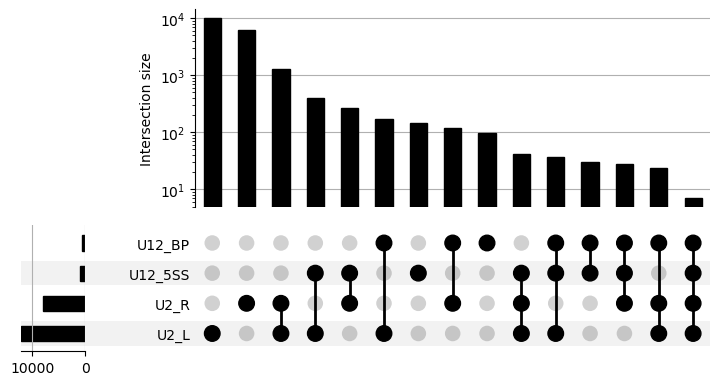

In [114]:
ax_dict = ups.UpSet(all_u2_u12, subset_size="count",sort_by='cardinality').plot()
_=plt.yscale('log')

In [92]:
#For each category, are surrounding exons alternative?
u2_u12_df[(u2_u12_df['U2_L'] & u2_u12_df['U12_BP'])]
#Get intron coordinates (introns_df), and find exons in same Chr with start/end around intron

#Find exon in rmats output 

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,U2_R,U2_L,U12_BP,U12_5SS
275,SckGQDu_9;HRSCAF=16,2927316,2928527,TTTTCTTACAGGTAAGTTACTAGTCTAGAAT,AACCCAAACTCTCATTCTCTTTTCTTTCAGTATCAATATTT,Ex_Ex,GT/AG,False,NaN,False,1211,True,True,True,True
284,SckGQDu_9;HRSCAF=16,3017248,3021125,ACAGTTGAAAGGTCAATAAACCAGTCAATTA,TGAATGTTTCTTCTTTCTTCTCATTCATAGGATGGTTGAAG,Ex_Ex,GT/AG,False,NaN,False,3877,False,True,True,False
288,SckGQDu_9;HRSCAF=16,3022577,3031065,GCCCAATCAAGGTATGTTTTTTTTTGTTTGT,GTCATTTCCACCTGTCGTTATTTTTTTCAGGGTGATGGGTA,Ex_Ex,GT/AG,False,NaN,False,8488,False,True,True,False
320,SckGQDu_9;HRSCAF=16,3489251,3490763,AAACATTAAAGGTTTGTTTTTCCATATTTAT,ATAAAACAACACATTTTCTTACTTTTCTAGGGCCGTTTGGA,Ex_Ex,GT/AG,False,NaN,False,1512,False,True,True,False
480,SckGQDu_9;HRSCAF=16,6987375,6987816,GGTAGAGAGAGGTACCTTGTCAATTGATTTT,GATACGAACATTATCACTTTCCTTAACTAGAAACAACAACA,Ex_Ex,GT/AG,False,NaN,False,441,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23235,SckGQDu_198;HRSCAF=491,16719418,16724117,AAGCGCTAAAGGTAATCCTTTCTCTTGACGC,TTAAAATTCAATCCTTATTCTATTATTCAGATATTTTTTCC,Ex_Ex,GT/AG,False,NaN,False,4699,False,True,True,False
23313,SckGQDu_198;HRSCAF=491,20362059,20363284,AGTTGATGGAGGTATAATTTTCATCGCTTCA,CGTGTATTATAAATAAAGTTTTTTTTTCAGGAACGAACAAA,Ex_Ex,GT/AG,False,NaN,False,1225,False,True,True,False
23339,SckGQDu_198;HRSCAF=491,20627136,20671132,TCATCAAGAAGGTAAGTGTTGTTTGTTTACC,ACTAAGTTGAATTCTCGTCATTCTTTTCAGGACATGAACAG,Ex_Ex,GT/AG,False,NaN,False,43996,True,True,True,False
23374,SckGQDu_198;HRSCAF=491,21124545,21124970,TATCTTCCAAGGTATCTATGACCTAACGTAT,TTAATGTAGTAATTGTTTTTCATTTTCAAGGTATTTTATTC,Ex_Ex,GT/AG,False,NaN,False,425,False,True,True,False


In [99]:
u2_u12_df[(u2_u12_df['U2_L'] & u2_u12_df['U12_5SS'])]

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,U2_R,U2_L,U12_BP,U12_5SS
113,SckGQDu_9;HRSCAF=16,1796457,1817332,GGTACTCCCAGGTACGGACTTTATCGTTCAA,ACTATAATATCGACTCGATTCTTTCATCAGGAAAAGACGAA,Ex_Ex,GT/AG,False,NaN,False,20875,False,True,False,True
158,SckGQDu_9;HRSCAF=16,2057216,2057564,ACCTTCTGCAGGTAAGAAATATCTAGAAAGA,ACTAGAACAATATTTAATTTCTGACCTTAGATTCAAGTAAG,Ex_Ex,GT/AG,False,NaN,False,348,True,True,False,True
220,SckGQDu_9;HRSCAF=16,2638390,2646966,ACCCACCACAGGTACGTCTCCTATCTTGTGT,AATTAATTTTTTAACTTCTTTATTTTTCAGAGTTGTATTTT,Ex_Ex,GT/AG,False,NaN,False,8576,False,True,False,True
275,SckGQDu_9;HRSCAF=16,2927316,2928527,TTTTCTTACAGGTAAGTTACTAGTCTAGAAT,AACCCAAACTCTCATTCTCTTTTCTTTCAGTATCAATATTT,Ex_Ex,GT/AG,False,NaN,False,1211,True,True,True,True
456,SckGQDu_9;HRSCAF=16,5882998,5883653,TGCATTATCAGGTACACTTTTTTCATAAGAA,ATATCTTAAATCCTTTATGTCACTTTTCAGGAACTTTGAAG,Ex_Ex,GT/AG,False,NaN,False,655,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23232,SckGQDu_198;HRSCAF=491,16715171,16716197,CCCGAATGTAGGTGAGTCAAAGCTCTCTAAT,ATACATATCCTTAATGATTATCGATTTTAGGGACTCGCGAT,Ex_Ex,GT/AG,False,NaN,False,1026,False,True,False,True
23248,SckGQDu_198;HRSCAF=491,17753475,17755903,TTTTTGTCAAGGTATTTTTTTCTTAGTTTGT,ATTATAATCTTTTTGTTTCTCCCTTTCTAGGTTCTAGTCGT,Ex_Ex,GT/AG,False,NaN,False,2428,False,True,False,True
23318,SckGQDu_198;HRSCAF=491,20413125,20416428,CGATTACAAAGGTGAGGGAAATTTGTCTAGG,TCAACTGTATTTTGACTTCTTTTGTTTTAGCCGATTGGTTA,Ex_Ex,GT/AG,False,NaN,False,3303,False,True,False,True
23535,SckGQDu_148;HRSCAF=334,7877118,7878556,ATACTTTAAAGGTAAATTTTGGTTCTTTTGT,TATAATGTATTATCCTTCTTTCATGTATAGGCTGGCGTCAC,Ex_Ex,GT/AG,False,NaN,False,1438,False,True,False,True


In [107]:
u2_u12_df[(u2_u12_df['U2_R'] & u2_u12_df['U12_5SS'])]

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,Short_Intron,AGGT_Dists,Likely_Recurs,length,U2_R,U2_L,U12_BP,U12_5SS
2,SckGQDu_8;HRSCAF=15,355731,356010,ATTTTTCAGTGGTAAGTCATTTTTGAACTTT,TATTCAATTTTCATCGAATTCCTTTTGTAGATGATGTCAAG,Ex_Ex,GT/AG,False,NaN,False,279,True,False,False,True
99,SckGQDu_9;HRSCAF=16,1663388,1663979,CTGAGAAAGTGGTAAGTATATAAATGATTTT,AAAAAATCCTATTGTTTTATAAAATGTCAGGTTGAAATTTC,Ex_Ex,GT/AG,False,NaN,False,591,True,False,False,True
155,SckGQDu_9;HRSCAF=16,2056035,2056420,GTACAAGTTCAGTAAGTTTTGTTATTAGTTG,TTTTTAATGGTAAGATAAATTCTCTATTAGAGTGGAAAATC,Ex_Ex,GT/AG,False,NaN,False,385,True,False,False,True
158,SckGQDu_9;HRSCAF=16,2057216,2057564,ACCTTCTGCAGGTAAGAAATATCTAGAAAGA,ACTAGAACAATATTTAATTTCTGACCTTAGATTCAAGTAAG,Ex_Ex,GT/AG,False,NaN,False,348,True,True,False,True
271,SckGQDu_9;HRSCAF=16,2896352,2897009,TCAACCAACTGGTAAGTGATTGAATTATTTC,CAGAGGCTTATTCTATCAATTTTTCCCTAGAAACCGCCACA,Ex_Ex,GT/AG,False,NaN,False,657,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22827,SckGQDu_198;HRSCAF=491,8118457,8134004,AAATTCTAAAAGTAAGTTGCGACATCTCTGA,ATGTTTAATTTCATATTTGTCTTCTTCTAGATGACGATTCA,Ex_Ex,GT/AG,False,NaN,False,15547,True,False,False,True
22829,SckGQDu_198;HRSCAF=491,8129683,8155061,ATGAACTCAAGGTAAGTTTTACGATTTCCAG,TAAAGATATTTTTGTGGTATTTTTCCATAGAAATATGTCGT,Ex_Ex,GT/AG,False,NaN,False,25378,True,True,False,True
22841,SckGQDu_198;HRSCAF=491,8172526,8187757,GAAGGCGAAAGGTAAGAAAGATATTAAAATT,TTTCTTCATTATTTTTCTTTTTTTCTTTAGTTTACCAAGCT,Ex_Ex,GT/AG,False,NaN,False,15231,True,True,True,True
23198,SckGQDu_198;HRSCAF=491,15503372,15507943,TATTCGACAAGGTAAGAAATTTGAAAAATAA,GAAATGATAGTATACTTTTTAATGTTTTAGGTTTTCGAAGG,Ex_Ex,GT/AG,False,NaN,False,4571,True,True,False,True


In [49]:
#rmats results
data_path = '/home/tchari/clytia_alt_splice/rmats_out/'
singles = ['p2','mf','m','go','fedsw_mf_2']
comps = ['mf_p2', 'mf_m','p2_go','mf_go','nem_starv_2','fs','neur_fs','neur_icell'] # nem_starv_2
all_data = singles+comps


data_arr = []
for d in all_data:
    p=data_path+'rmats_'+d+'.tar.gz'
    print(p)
    data_arr+=[read_rmats(p)]


/home/tchari/clytia_alt_splice/rmats_out/rmats_p2.tar.gz
SE
MXE
RI
A5SS
/home/tchari/clytia_alt_splice/rmats_out/rmats_mf.tar.gz
SE
MXE
RI
A5SS
/home/tchari/clytia_alt_splice/rmats_out/rmats_m.tar.gz
SE
MXE
RI
A5SS
/home/tchari/clytia_alt_splice/rmats_out/rmats_go.tar.gz
SE
MXE
A3SS
RI
A5SS
/home/tchari/clytia_alt_splice/rmats_out/rmats_fedsw_mf_2.tar.gz
SE
MXE
A3SS
RI
A5SS
/home/tchari/clytia_alt_splice/rmats_out/rmats_mf_p2.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_mf_m.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_p2_go.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_mf_go.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_nem_starv_2.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_fs.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_neur_fs.tar.gz
/home/tchari/clytia_alt_splice/rmats_out/rmats_neur_icell.tar.gz


In [52]:
from spliceformats.shrinkage import shrink_rMATS

corr_data=[shrink_rMATS(d) for d in data_arr]

In [55]:
fs_corr_data = corr_data[4]

In [57]:
fs_corr_data.data['SE'].chr = [i.replace('chr','') for i in fs_corr_data.data['SE'].chr]
fs_corr_data.data['SE']

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,...,SJC_SAMPLE_1,IJC_SAMPLE_2,SJC_SAMPLE_2,IncFormLen,SkipFormLen,PValue,FDR,IncLevel1,IncLevel2,IncLevelDifference
0,0,MSTRG.9139,NaN,SckGQDu_149;HRSCAF=336,+,25873255,25873420,25870991,25871777,25874181,...,"0,0",NaN,NaN,300,150,NaN,NaN,"NA,NA",NaN,NaN
1,1,MSTRG.9137,NaN,SckGQDu_149;HRSCAF=336,-,25782981,25783071,25781790,25782059,25783561,...,"9,17",NaN,NaN,240,150,NaN,NaN,"0.78,0.901",NaN,NaN
2,2,MSTRG.9124,NaN,SckGQDu_149;HRSCAF=336,-,26094630,26094702,25542738,25542810,26103830,...,"4,37",NaN,NaN,222,150,NaN,NaN,"0.253,0.192",NaN,NaN
3,3,MSTRG.9061,NaN,SckGQDu_149;HRSCAF=336,-,24537265,24537406,24536807,24536957,24538695,...,"0,0",NaN,NaN,291,150,NaN,NaN,"1.0,1.0",NaN,NaN
4,4,MSTRG.9057,NaN,SckGQDu_149;HRSCAF=336,-,24515841,24515872,24515314,24515384,24516589,...,"0,0",NaN,NaN,181,150,NaN,NaN,"1.0,1.0",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,2492,MSTRG.13710,NaN,SckGQDu_178;HRSCAF=400,+,1985448,1985522,1984754,1984829,1985814,...,"15,22",NaN,NaN,224,150,NaN,NaN,"0.043,0.084",NaN,NaN
2493,2493,MSTRG.21048,NaN,SckGQDu_37;HRSCAF=66,-,150674,150759,149929,150064,151038,...,"0,3",NaN,NaN,235,150,NaN,NaN,"1.0,0.299",NaN,NaN
2494,2494,MSTRG.10724,NaN,SckGQDu_151;HRSCAF=341,+,5324376,5324472,5323822,5323916,5324844,...,"60,28",NaN,NaN,246,150,NaN,NaN,"0.58,0.489",NaN,NaN
2495,2495,MSTRG.21059,NaN,SckGQDu_3;HRSCAF=8,+,223872,223986,219997,220109,224191,...,"0,0",NaN,NaN,264,150,NaN,NaN,"1.0,1.0",NaN,NaN


In [71]:
fs_corr_data.data['SE'][(fs_corr_data.data['SE'].chr == 'SckGQDu_9;HRSCAF=16') & (fs_corr_data.data['SE'].GeneID == 'MSTRG.24721')]

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,...,SJC_SAMPLE_1,IJC_SAMPLE_2,SJC_SAMPLE_2,IncFormLen,SkipFormLen,PValue,FDR,IncLevel1,IncLevel2,IncLevelDifference
276,276,MSTRG.24721,NaN,SckGQDu_9;HRSCAF=16,+,3016477,3016554,3015638,3015707,3016791,...,"2,0",NaN,NaN,227,150,NaN,NaN,"0.498,1.0",NaN,NaN


In [97]:
#Freq of U12 8-mers in introns vs expected
# no_introns*median_intron_leng*
expec_u12 = len(sub)*(np.median(list(sub.length))-8+1)*np.pow((1/4),8)
print('Expected Occ. U12 8-mer in introns: ',expec_u12)



#LATER look for snRNAs in gene seqs

Expected Occ. U12 8-mer in introns:  161.3212890625


In [186]:
23390*(456-8+1)*np.pow(1/4,8)

np.float64(160.24948120117188)

In [187]:
np.sum(list(u2_u12_df['U12_BP']))

np.int64(511)

In [188]:
23390*(456-8+1)*np.pow(1/4,7)*(1/2)

np.float64(320.49896240234375)

In [189]:
np.sum(list(u2_u12_df['U12_5SS']))

np.int64(959)

### **Same for bulk**

/tmp/ipykernel_2965681/1053824825.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = sj_df.iloc[i][0]
/tmp/ipykernel_2965681/1053824825.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = sj_df.iloc[i][1]
/tmp/ipykernel_2965681/1053824825.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = sj_df.iloc[i][2]
/home/tchari/rmats_conda_env/lib/python3.10/site-packages/logomaker/src/matrix.py:270: FutureWarning: Set

,Chr,Start,End,5_SS,3_SS,SJ_Type,SJ_Motif,St_End_Recurs,Short_Intron,AGGT_Dists,length,Transcript,U2_R,U2_L,U12_BP,U12_5SS,U12_BP_Ind,U12_5SS_Ind,U12_5SS_Count
0,SckGQDu_9;HRSCAF=16,426716,427189,CCGATGTAAAGGTATAATCAATTGATATTTT,AATTTAATCAAGACTATCTTTCTCTTTCAGGCCTATATGGA,Ex_Ex,GT/AG,False,False,NaN,474,MSTRG.24540.1.p1,False,True,False,False,NaN,NaN,NaN
1,SckGQDu_9;HRSCAF=16,427296,428266,CGCAATCACAGGTAATAATTTGCACCAGGAA,TCTTTCAGCTATCTTGCTATCGTTTTTCAGGTCAGCTTGAC,Ex_Ex,GT/AG,False,False,NaN,971,MSTRG.24540.1.p1,False,True,False,False,NaN,NaN,NaN
2,SckGQDu_9;HRSCAF=16,428410,428625,AGAAGGGCGAGGTACATTCCTTTTTTTAAGC,ATTTTATCTTCTTTTTTTTAATTCTTCTAGATGACGCTTCG,Ex_Ex,GT/AG,False,False,NaN,216,MSTRG.24540.1.p1,False,True,False,False,NaN,NaN,NaN
3,SckGQDu_9;HRSCAF=16,428903,429146,GTCTAACAAAGGTAAGGTGTTAGTGGCATTA,AAATCTGACGTCCTGGTTTCCATATTGCAGGTCTTTCTGGT,Ex_Ex,GT/AG,False,False,NaN,244,MSTRG.24540.1.p1,True,True,False,False,NaN,NaN,NaN
4,SckGQDu_9;HRSCAF=16,429255,429686,ACACTCTTTAGGTAAGCCTATTTCTTGTGTA,TCATTACACAAACTACTCTTTTCTTTGCAGGATTGGCTCAC,Ex_Ex,GT/AG,False,False,NaN,432,MSTRG.24540.1.p1,True,True,False,False,NaN,NaN,NaN


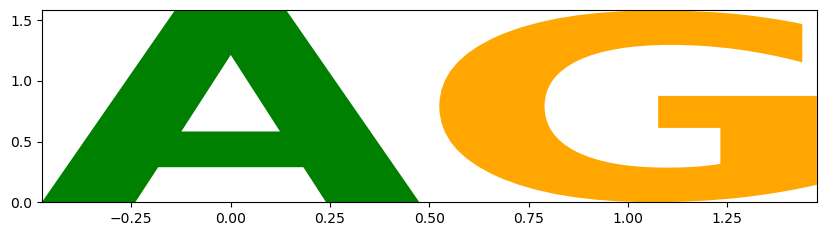

In [158]:
#sub = sc_seq_df[sc_seq_df.SJ_Type=='Ex_Ex'] #Can add additional introns_df filter~!!!!!
sub = pd.read_csv('real_introns_bulk_seq.csv') #real_introns_bulk_seq.csv

seqs = get_sj_seqs(sub,st_minus=12,end_plus=30)

counts_mat = lm.alignment_to_matrix([i[-32:-30]for i in seqs],to_type='information') #or [-60:-19]
lm.Logo(counts_mat,color_scheme='classic')

u12_bp = [False]*len(seqs)
bp_ind = [np.nan]*len(seqs)

u12_5ss = [False]*len(seqs)
ss5_ind = [np.nan]*len(seqs)
ss5_count = [np.nan]*len(seqs)

u2_L = [False]*len(seqs)
u2_R = [False]*len(seqs)
for s in range(len(seqs)):
    u2_R[s] = ((seqs[s][11:16] == 'GTAAG') & (seqs[s][-32:-30] == 'AG'))
    u2_L[s] = ((seqs[s][9:13] == 'AGGT') & (seqs[s][-32:-30] == 'AG'))

    bp_true = ('TCCTTAAC' in seqs[s])
    u12_bp[s] = bp_true
    if bp_true:
        bp_ind[s] = seqs[s].index('TCCTTAAC')
        
    ss5_true = (('GTATCCTT' in seqs[s]) or ('ATATCCTT' in seqs[s]))  # *************** SAVE INDICES TOO
    u12_5ss[s] = ss5_true 
    if ss5_true:
        if ('GTATCCTT' in seqs[s]):
            ss5_ind[s] = seqs[s].index('GTATCCTT')
            ss5_count[s] = seqs[s].count('GTATCCTT')
        else:
            ss5_ind[s] = seqs[s].index('ATATCCTT')
            ss5_count[s] = seqs[s].count('ATATCCTT')


u2_u12_bulk_df = sub.copy()
u2_u12_bulk_df['U2_R'] = u2_R
u2_u12_bulk_df['U2_L'] = u2_L
u2_u12_bulk_df['U12_BP'] = u12_bp
u2_u12_bulk_df['U12_5SS'] = u12_5ss

u2_u12_bulk_df['U12_BP_Ind'] = bp_ind
u2_u12_bulk_df['U12_5SS_Ind'] = ss5_ind
u2_u12_bulk_df['U12_5SS_Count'] = ss5_count
u2_u12_bulk_df.head()


In [159]:
from upsetplot import from_contents

u2_r_true = list(u2_u12_bulk_df.index[u2_u12_bulk_df['U2_R']])
u2_l_true = list(u2_u12_bulk_df.index[u2_u12_bulk_df['U2_L']])
u12_bp_true = list(u2_u12_bulk_df.index[u2_u12_bulk_df['U12_BP']])
u12_5ss_true = list(u2_u12_bulk_df.index[u2_u12_bulk_df['U12_5SS']])

all_u2_u12 = from_contents(
    {"U2_R": u2_r_true, "U2_L": u2_l_true, "U12_BP": u12_bp_true, "U12_5SS":u12_5ss_true}
)
all_u2_u12

/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
U2_R  U2_L  U12_BP U12_5SS       
True  True  False  False        3
                   False        4
      False False  False        7
                   False        8
      True  False  False       12
...                           ...
False False False  True     34812
                   True     35163
                   True     35309
                   True     35755
                   True     35817

[29060 rows x 1 columns]

/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/tchari/rmats_conda_env/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

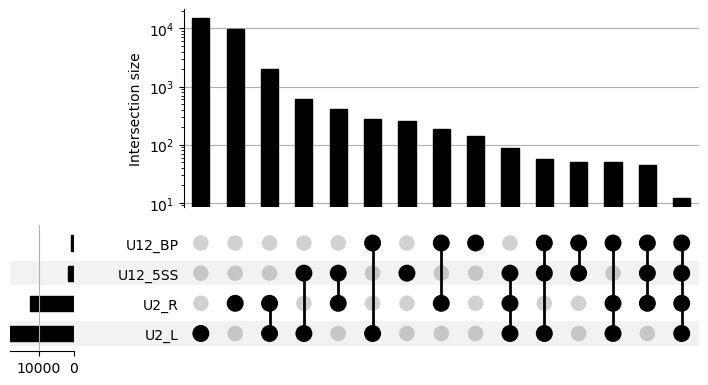

In [160]:
ax_dict = ups.UpSet(all_u2_u12, subset_size="count",sort_by='cardinality').plot()
_=plt.yscale('log')